# Анализ клиентских покупок

## Цель проекта
Разработать аналитическую модель, позволяющую выявить закономерности в покупательском поведении клиентов, а также построить предсказание вероятности совершения целевого действия — покупки товаров определённой категории. На основе анализа предполагается сформировать практические рекомендации для персонализации маркетинга и повышения конверсии.

## Источник данных
В проекте используются обезличенные данные о транзакциях клиентов, информация о товарах, а также сопутствующие данные о клиентских сегментах и историях взаимодействия (рассылки, рекламные кампании).

## Этапы работы
1. Первичный анализ и визуализация данных.
2. Очистка и подготовка данных (обработка пропусков, приведение форматов).
3. Построение признаков на основе истории покупок и поведения клиентов.
4. Объединение датасетов в единую таблицу для моделирования.
5. Построение и обучение модели классификации (целевая переменная — факт покупки товара категории X).
6. Оценка качества модели, анализ важности признаков.
7. Формирование выводов и бизнес-рекомендаций на основе модели и анализа.

## Ожидаемый результат
- Определение ключевых признаков, влияющих на поведение клиентов.
- Сегментация клиентов по поведенческим паттернам.
- Выводы и рекомендации по персонализации предложений и маркетинговых акций.


## Описание данных

В проекте используются несколько датафреймов, содержащих различную информацию о клиентах, транзакциях и продуктах. Ниже приведено описание каждого из них.

### 1. `clients_df`
Содержит информацию о клиентах:

- `client_id` — уникальный идентификатор клиента.
- `gender` — пол клиента.
- `birth_year` — год рождения.
- `registration_date` — дата регистрации клиента в системе.
- `region` — регион проживания клиента.

### 2. `transactions_df`
История покупок клиентов:

- `transaction_id` — уникальный идентификатор транзакции.
- `client_id` — идентификатор клиента, совершившего покупку.
- `product_id` — идентификатор купленного товара.
- `purchase_date` — дата и время покупки.
- `amount` — количество купленного товара.
- `total_price` — сумма покупки (в денежном выражении).

### 3. `products_df`
Информация о продуктах:

- `product_id` — уникальный идентификатор товара.
- `product_name` — наименование товара.
- `category` — категория товара.
- `cluster` — кластеризация товаров (например, по типу или назначению).

### 4. `campaigns_df`
История маркетинговых коммуникаций:

- `client_id` — идентификатор клиента.
- `campaign_date` — дата отправки маркетингового сообщения.
- `campaign_type` — тип кампании (email, push, sms и т.д.).
- `response` — реакция клиента (например, клик, покупка, игнорирование).

### 5. `target_df`
Целевая переменная для моделирования:

- `client_id` — идентификатор клиента.
- `apparel_target_binary` — бинарная переменная, обозначающая факт покупки товара из категории "одежда" (1 — была покупка, 0 — не было).

Эти таблицы объединяются по `client_id` и `product_id` (там, где применимо) для построения единой аналитической модели.


## Загрузка данных
### Загрузка необходимых библиотек

In [1]:
pip install phik -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Основные библиотеки
import pandas as pd
import numpy as np

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

# Специализированные библиотеки для анализа данных
from phik import phik_matrix

# Предобработка данных
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Модели машинного обучения
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier

# Метрики оценки моделей
from sklearn.metrics import (
    classification_report, 
    roc_auc_score, 
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    roc_curve
)

# Отключение предупреждений
import warnings
warnings.filterwarnings('ignore')


### Загрузка таблиц

In [3]:
import pandas as pd

# Настройки отображения
pd.set_option('display.max_columns', None)

# Словарь с именами файлов и переменными
file_map = {
    "apparel-messages.csv": "messages_df",
    "apparel-purchases.csv": "purchases_df",
    "apparel-target_binary.csv": "target_df",
    "full_campaign_daily_event.csv": "campaign_event_df",
    "full_campaign_daily_event_channel.csv": "campaign_channel_df"
}

# Загрузка файлов CSV с контролем ошибок
dataframes = {}
for file, var_name in file_map.items():
    try:
        df = pd.read_csv(file, encoding='utf-8', sep=',')  # можно добавить `parse_dates=[...]`, если есть даты
        dataframes[var_name] = df
        print(f"Загружен: {file} → {var_name} ({df.shape[0]} строк, {df.shape[1]} столбцов)")
    except Exception as e:
        print(f"Ошибка при загрузке {file}: {e}")

# Присваиваем переменные
globals().update(dataframes)


Загружен: apparel-messages.csv → messages_df (12739798 строк, 7 столбцов)
Загружен: apparel-purchases.csv → purchases_df (202208 строк, 6 столбцов)
Загружен: apparel-target_binary.csv → target_df (49849 строк, 2 столбцов)
Загружен: full_campaign_daily_event.csv → campaign_event_df (131072 строк, 24 столбцов)
Загружен: full_campaign_daily_event_channel.csv → campaign_channel_df (131072 строк, 36 столбцов)


Так же сразу помсмотрим на общую информацию загруженных таблиц

In [4]:
# Словарь всех загруженных датафреймов
data_dic = {
    'messages_df': messages_df,
    'purchases_df': purchases_df,
    'target_df': target_df,
    'campaign_event_df': campaign_event_df,
    'campaign_channel_df': campaign_channel_df
}

# Просмотр общей информации по всем датафреймам
for name, df in data_dic.items():
    print(f"\n{'='*30}")
    print(f"Датафрейм: {name}")
    print(f"{'='*30}")
    
    print("Общая информация:")
    print(df.info())
    
    print("\n Описательная статистика (числовые признаки):")
    print(df.describe().T)
    
    missing = df.isnull().sum()
    missing = missing[missing > 0]
    
    if not missing.empty:
        print(missing)
    else:
        print('Нет пропущенных значений')



Датафрейм: messages_df
Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB
None

 Описательная статистика (числовые признаки):
                       count          mean           std           min  \
bulk_campaign_id  12739798.0  1.160459e+04  3.259211e+03  5.480000e+02   
client_id         12739798.0  1.515916e+18  3.265518e+08  1.515916e+18   

                           25%           50%           75%           max  
bulk_campaign_id  8.746000e+03  1.351600e+04  1.415800e+04  1.465700e+04  
client_id         1.515916e+18  1.515916e+18  1.515916e+18  1.515916e+18  
Нет пропущенных значен

***Итоги осмотра данных***

1. **Общий объём данных**
   - Самый крупный датафрейм — `messages_df`, содержит более 12 млн записей о коммуникациях с клиентами.
   - Остальные таблицы варьируются от ~49 тыс. (`target_df`) до ~200 тыс. (`purchases_df`) и ~130 тыс. (`campaign_*`).

2. **Типы данных**
   - Почти во всех таблицах имеются признаки типа `object`, представляющие даты — они требуют приведения к формату `datetime`.

3. **Пропущенные значения**
   - Во всех датафреймах **пропусков нет** — это упрощает дальнейшую обработку.

4. **Аномалии**
   - В таблицах `campaign_event_df` и `campaign_channel_df` встречаются экстремальные значения (миллионы отправок, открытия, клики) — необходимо будет использовать логарифмическое масштабирование или отсечение выбросов.



## Предобработка данных
### Изменение типа данных у дат

In [5]:
# Словарь: имя датафрейма → список столбцов, которые нужно привести к datetime
date_columns = {
    'messages_df': ['date', 'created_at'],
    'purchases_df': ['date'],
    'campaign_event_df': ['date'],
    'campaign_channel_df': ['date']
}

# Преобразование дат
for df_name, cols in date_columns.items():
    df = globals().get(df_name)
    if df is not None:
        for col in cols:
            if col in df.columns:
                try:
                    df[col] = pd.to_datetime(df[col], errors='coerce')
                    print(f" {df_name}.{col} успешно преобразован в datetime")
                except Exception as e:
                    print(f" Ошибка при преобразовании {df_name}.{col}: {e}")
            else:
                print(f" Столбец {col} не найден в {df_name}")
    else:
        print(f" Датафрейм {df_name} не найден")


 messages_df.date успешно преобразован в datetime
 messages_df.created_at успешно преобразован в datetime
 purchases_df.date успешно преобразован в datetime
 campaign_event_df.date успешно преобразован в datetime
 campaign_channel_df.date успешно преобразован в datetime


### Проверка целостности связей и потенциальных несостыковок между таблицами

- Есть ли в target_df такие клиенты, которых нет в других таблицах (например, не совершали покупок или не получали сообщений)?

- Есть ли в purchases_df или messages_df клиенты, которых нет в target_df?

- Соответствуют ли message_id в purchases_df сообщениям из messages_df?

In [6]:
# Проверка пересечений по client_id
clients_in_target = set(target_df['client_id'])
clients_in_purchases = set(purchases_df['client_id'])
clients_in_messages = set(messages_df['client_id'])

print(" Кол-во клиентов в target_df:", len(clients_in_target))
print(" Кол-во клиентов в purchases_df:", len(clients_in_purchases))
print(" Кол-во клиентов в messages_df:", len(clients_in_messages))

print("\n Пересечения:")
print("Клиенты и в target, и в purchases:", len(clients_in_target & clients_in_purchases))
print("Клиенты и в target, и в messages:", len(clients_in_target & clients_in_messages))
print("Клиенты и в purchases, и в messages:", len(clients_in_purchases & clients_in_messages))
print("Во всех трёх таблицах:", len(clients_in_target & clients_in_purchases & clients_in_messages))

print("\n Уникальные (в target, но нет в purchases):", len(clients_in_target - clients_in_purchases))
print(" Уникальные (в purchases, но нет в target):", len(clients_in_purchases - clients_in_target))

# Проверка соответствий по message_id
msg_in_purchases = set(purchases_df['message_id'])
msg_in_messages = set(messages_df['message_id'])

print("\n Кол-во message_id в purchases:", len(msg_in_purchases))
print(" Кол-во message_id в messages:", len(msg_in_messages))

print("\n Пересечения по message_id:")
print("message_id и в purchases, и в messages:", len(msg_in_purchases & msg_in_messages))
print(" В purchases, но нет в messages:", len(msg_in_purchases - msg_in_messages))
print(" В messages, но нет в purchases:", len(msg_in_messages - msg_in_purchases))


 Кол-во клиентов в target_df: 49849
 Кол-во клиентов в purchases_df: 49849
 Кол-во клиентов в messages_df: 53329

 Пересечения:
Клиенты и в target, и в purchases: 49849
Клиенты и в target, и в messages: 41982
Клиенты и в purchases, и в messages: 41982
Во всех трёх таблицах: 41982

 Уникальные (в target, но нет в purchases): 0
 Уникальные (в purchases, но нет в target): 0

 Кол-во message_id в purchases: 50204
 Кол-во message_id в messages: 9061667

 Пересечения по message_id:
message_id и в purchases, и в messages: 49810
 В purchases, но нет в messages: 394
 В messages, но нет в purchases: 9011857


---

***Вывод по анализу client_id***

- Все клиенты из `target_df` и `purchases_df` полностью совпадают — 49849 уникальных `client_id`. Это упрощает обучение модели, так как нет пропущенных меток.
- В `messages_df` содержится 53329 клиентов, однако только 41982 из них пересекаются с `target_df` и `purchases_df`. Это означает, что около **16% клиентов** из обучающей выборки **не получали сообщений**.
- Таким образом, **ядро для обучения и анализа реакций на сообщения** составляет **41982 клиента**, у которых есть:
  - история покупок,
  - целевая переменная,
  - история маркетинговых сообщений.

Этот факт следует учитывать при формировании обучающей выборки и при анализе эффективности маркетинга: не у всех клиентов была коммуникация перед покупкой.


### Проверка таблиц на наличие дубликатоов

Удалять будем только полные дубликаты строк, так как в остальных случаях повторы данных - нормальное их поведение


In [7]:
for df_name in ['messages_df', 'purchases_df', 'target_df', 'campaign_event_df', 'campaign_channel_df']:
    df = globals().get(df_name)
    if df is not None:
        before = df.shape[0]
        df.drop_duplicates(inplace=True)
        after = df.shape[0]
        removed = before - after
        print(f" {df_name}: удалено {removed} полных дубликатов (было: {before}, стало: {after})")
    else:
        print(f" {df_name} не найден")

 messages_df: удалено 48610 полных дубликатов (было: 12739798, стало: 12691188)
 purchases_df: удалено 73020 полных дубликатов (было: 202208, стало: 129188)
 target_df: удалено 0 полных дубликатов (было: 49849, стало: 49849)
 campaign_event_df: удалено 0 полных дубликатов (было: 131072, стало: 131072)
 campaign_channel_df: удалено 0 полных дубликатов (было: 131072, стало: 131072)


## Разведочный анализ данных

Для начала напишем функции для удобной визуализации признаков

In [8]:
# Универсальная функция для числовых признаков
def plot_numeric_distribution(df, columns, log_scale=False, clip_quantile=0.99, bins=50):
    for col in columns:
        plt.figure(figsize=(8, 4))
        data = df[col].dropna()

        if clip_quantile:
            upper = data.quantile(clip_quantile)
            data = data[data <= upper]

        sns.histplot(data, bins=bins, kde=False)
        if log_scale:
            plt.yscale('log')
        plt.title(f'Распределение признака: {col}')
        plt.xlabel(col)
        plt.ylabel('Частота')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Универсальная функция для категориальных/дискретных
def plot_value_counts(df, columns, top_n=20):
    for col in columns:
        plt.figure(figsize=(10, 4))
        value_counts = df[col].value_counts().head(top_n)
        sns.barplot(x=value_counts.index.astype(str), y=value_counts.values)
        plt.title(f'Топ-{top_n} значений признака: {col}')
        plt.xlabel(col)
        plt.ylabel('Частота')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

### Анализ покупок клиентов (`purchases_df`)

-  Распределение количества покупок на клиента
-  Распределение суммы трат на клиента
-  Распределение цен товаров (и выявление выбросов)
-  Распределение количества товаров в заказе (`quantity`)
-  Динамика покупок по времени


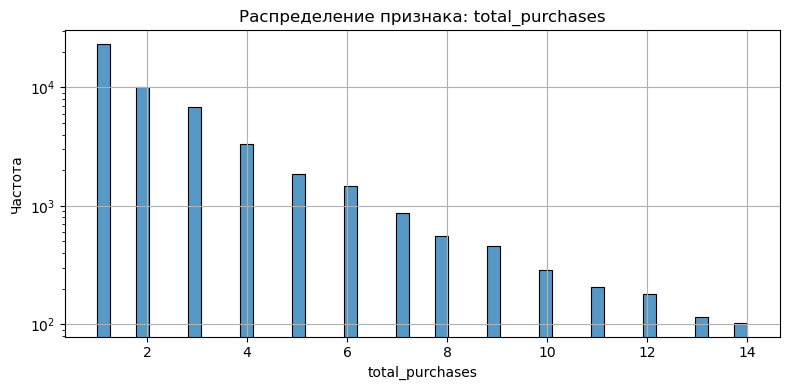

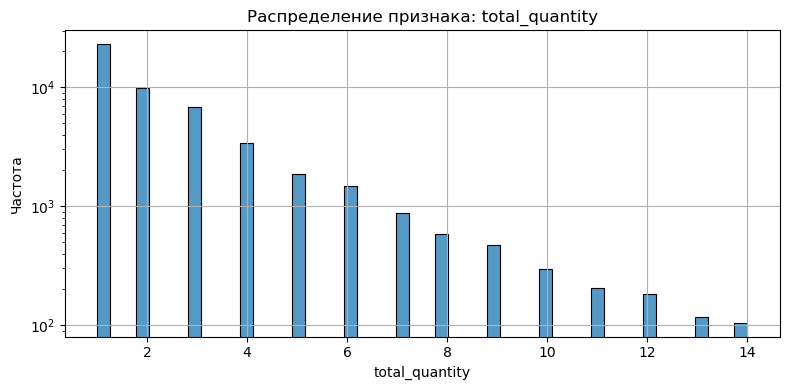

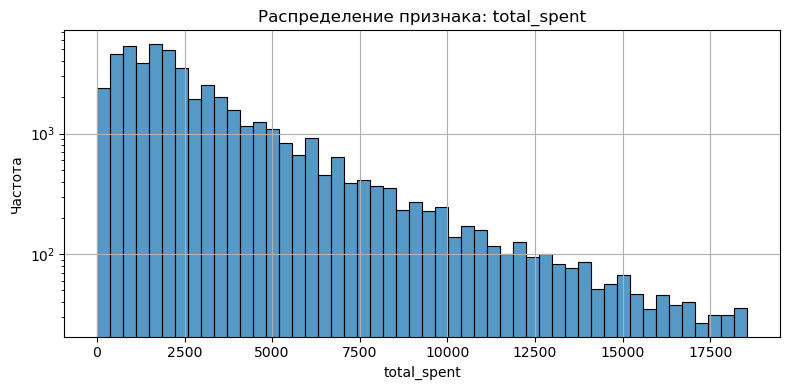

In [9]:
purchase_summary = purchases_df.groupby('client_id').agg(
    total_purchases=('message_id', 'count'),
    total_quantity=('quantity', 'sum'),
    total_spent=('price', 'sum'),
    avg_price=('price', 'mean'),
    first_purchase=('date', 'min'),
    last_purchase=('date', 'max')
).reset_index()

plot_numeric_distribution(purchase_summary, ['total_purchases', 'total_quantity', 'total_spent'], log_scale=True)


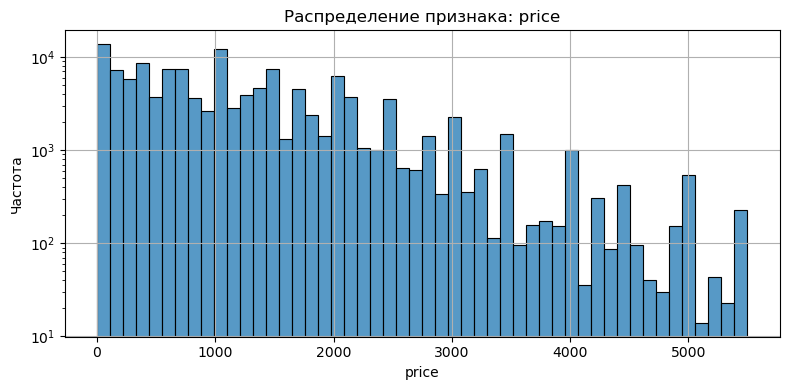

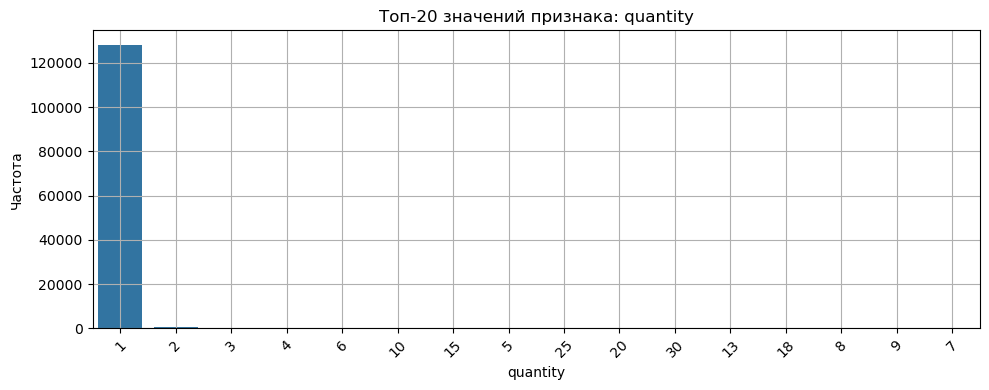

In [10]:
plot_numeric_distribution(purchases_df, ['price'], log_scale=True)
plot_value_counts(purchases_df, ['quantity'])


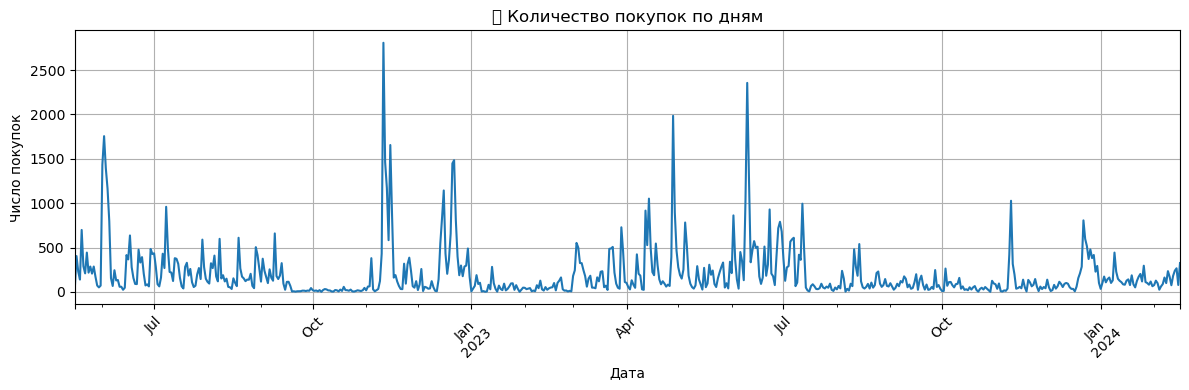

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
purchases_df['date'].value_counts().sort_index().plot()
plt.title('⏰ Количество покупок по дням')
plt.xlabel('Дата')
plt.ylabel('Число покупок')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


####  Анализ покупок клиентов

#####  Количество покупок и заказанных единиц товара (`total_purchases`, `total_quantity`)
- Распределение скошено вправо (лог-нормальное), большинство клиентов совершают от 1 до 3 покупок.
- Кол-во покупателей резко убывает с ростом активности — есть небольшое число "сверхактивных" клиентов.
- Поведение по `total_quantity` аналогично — в основном заказывают от 1 до 5 единиц товара.

#####  Общая сумма трат (`total_spent`)
- Наблюдается широкий диапазон трат, от небольших (~1000) до крупных (более 25000).
- Распределение имеет тяжёлый правый хвост - присутствуют высокозатратные клиенты.
- Возможно, стоит проверить верхний 1% покупателей на предмет VIP или корпоративных заказов.

#####  Цены товаров (`price`)
- Цены варьируются от минимальных до 5000+ — признаки товаров разных категорий.
- Распределение равномерное с пиками - возможны ценовые "ступени" (популярные ценовые зоны).
- Логарифмическая шкала оправдана: разница между самым дешёвым и дорогим товаром — в десятки раз.

#####  Количество товара в заказе (`quantity`)
- Почти все покупки совершаются с `quantity = 1` (доминирующее значение).
- Остальные значения (2, 3, 5, 10, 30) — встречаются крайне редко - можно рассматривать как выбросы или специфические случаи (например, оптовые покупки).

#####  Активность по датам
- Чёткие пиковые всплески по числу покупок - вероятны сезонные акции, маркетинговые кампании или скидочные периоды.
- Наиболее активные периоды — ноябрь-декабрь 2022, март-июнь 2023, ноябрь 2023.
- Между пиками — долгие "плато", что подтверждает цикличность спроса.

---

***Что стоит учесть для модели:***
- Можно выделить метки активных периодов (флаг "попал ли клиент в период с повышенной активностью").
- Поведение клиентов очень гетерогенное — часть клиентов делает 1 заказ, часть — 20+. Это важно для стратификации.



### Анализ целевой переменной (`target_df`)

- выявить дисбаланс классов (0 / 1),

- оценить, чем отличаются клиенты с target = 1 и target = 0,

- проверить, влияет ли количество покупок / трат на целевую метку.

In [12]:
# Универсальная функция для построения boxplot
def plot_box_by_target(df, metric_cols, target_col='target', log_scale=True):
    import matplotlib.pyplot as plt
    import seaborn as sns

    for col in metric_cols:
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=target_col, y=col, data=df)
        if log_scale:
            plt.yscale('log')
        plt.title(f'{col} по классам {target_col}')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

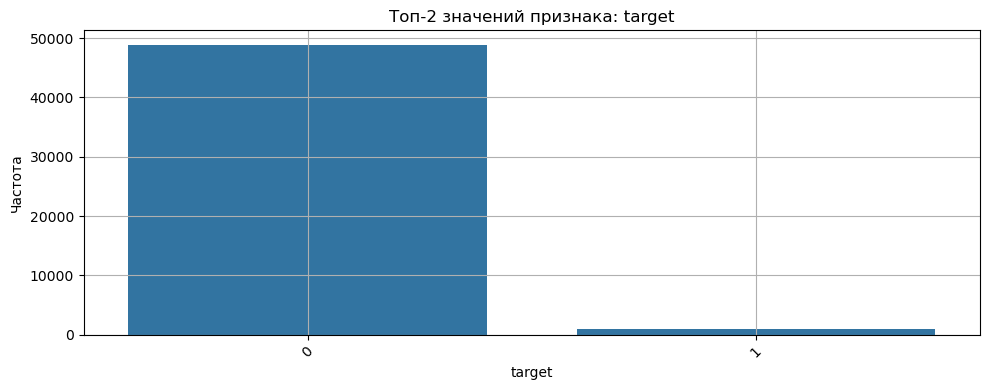

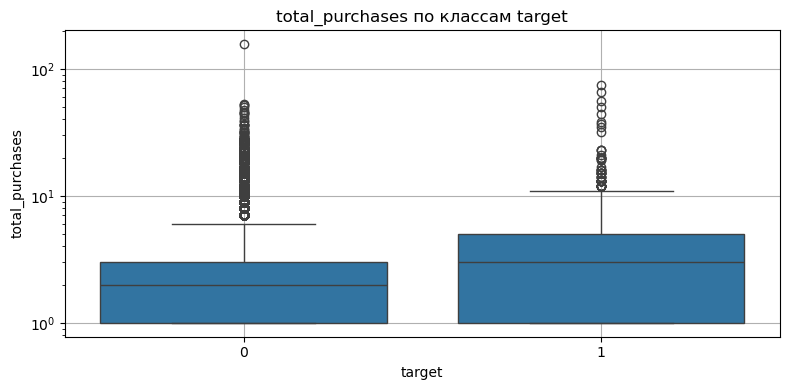

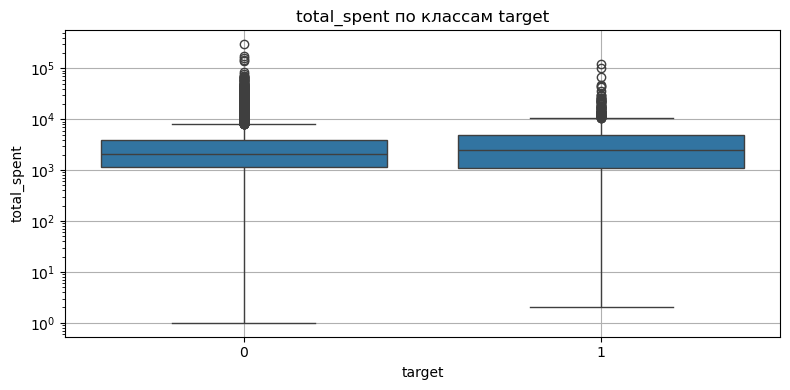

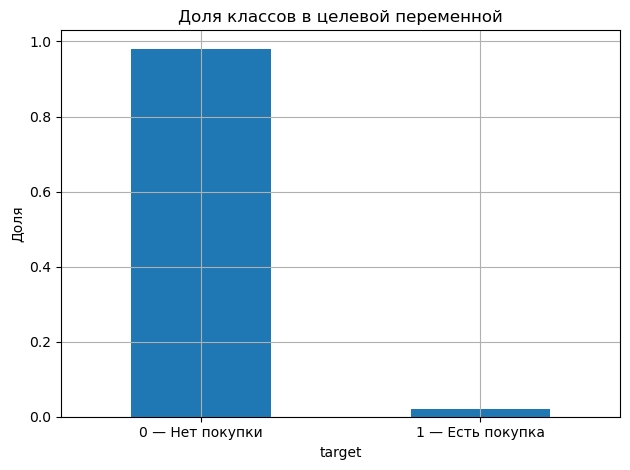

In [13]:
# Распределение целевой переменной
plot_value_counts(target_df, ['target'], top_n=2)

# Подключаем сводку по покупкам для сравнения с target
target_merged = target_df.merge(purchase_summary, on='client_id', how='left')

# Сравнение total_purchases и total_spent по классам
plot_box_by_target(target_merged, ['total_purchases', 'total_spent'])

# Проверка: доля клиентов с 0/1
target_df['target'].value_counts(normalize=True).plot(kind='bar', title='Доля классов в целевой переменной')
plt.xticks([0, 1], ['0 — Нет покупки', '1 — Есть покупка'], rotation=0)
plt.ylabel('Доля')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Анализ целевой переменной (`target`)

#####  Распределение классов (0 / 1)
- Целевая переменная `target` очень несбалансированная:
  - Класс 0 (не купили) — ~97% клиентов.
  - Класс 1 (купили в течение 90 дней) — ~3%.
- Это создаёт **сильный дисбаланс классов**, который потребуется учитывать при обучении модели (стратификация, oversampling/undersampling, использование AUC/ROC и т.д.).

#####  Покупки и траты по классам
- В среднем, клиенты из класса 1 совершают **больше покупок** и тратят **больше денег**, чем из класса 0.
- Однако распределения перекрываются — есть клиенты из класса 0 с высокими затратами, и из класса 1 — с малым числом покупок.
- Выбросы присутствуют в обоих классах, но особенно заметны в классе 0 (вероятно, это клиенты, покупавшие **вне нужного товарного сегмента**).
---
 ***Выводы:***
- Признаки `total_purchases` и `total_spent` потенциально полезны для модели, но **не являются строго разделяющими**.
- Потребуется создание **более поведенческих и контекстных признаков**: реакция на сообщения, время до покупки, каналы коммуникации.
- Балансировка классов будет **критически важной задачей** на этапе моделирования.


### Поведение клиентов в рассылках (`messages_df`)

-  Количество сообщений, полученных каждым клиентом
-  Распределение по `event`: отправка, открытие, клик, покупка
-  Активность по каналам (`channel`) и по времени (`date`, `created_at`)
-  Анализ отклика клиентов на сообщения (и временные задержки между отправкой и покупкой)


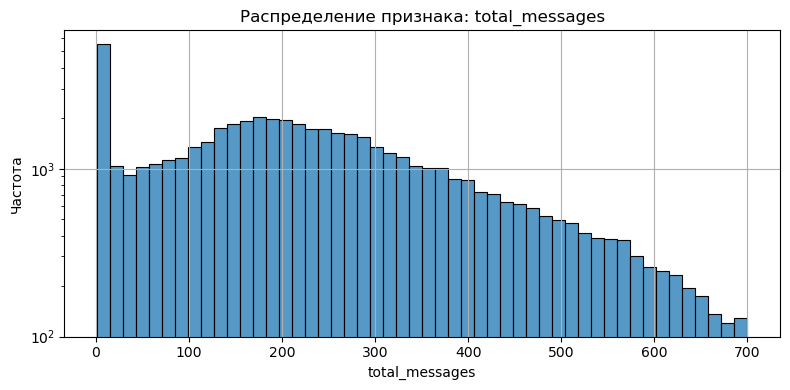

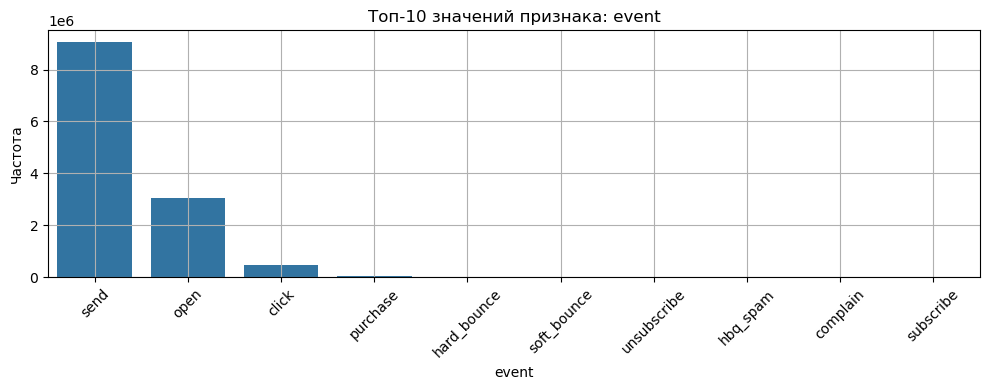

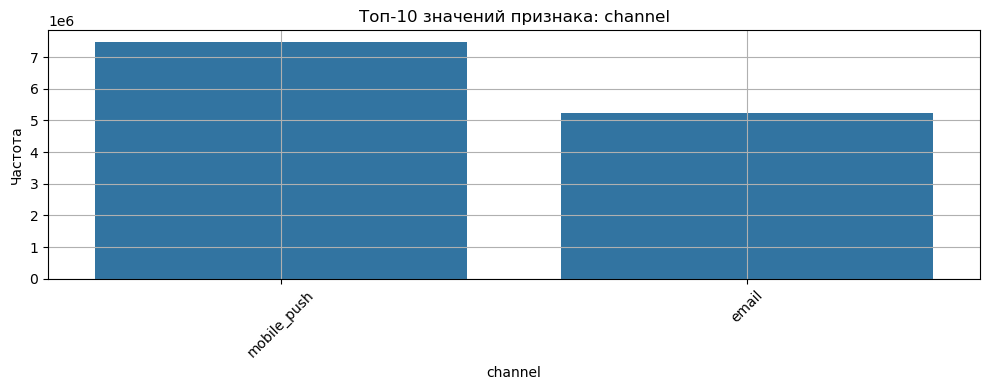

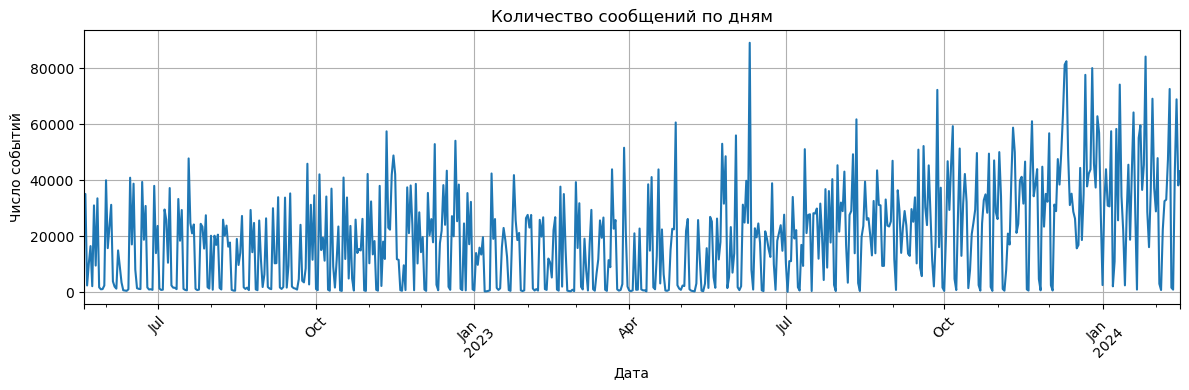

In [14]:
#  Кол-во сообщений на клиента
msg_counts = messages_df.groupby('client_id').agg(
    total_messages=('message_id', 'count')
).reset_index()

plot_numeric_distribution(msg_counts, ['total_messages'], log_scale=True)

#  Распределение событий (event)
plot_value_counts(messages_df, ['event'], top_n=10)

#  Распределение по каналам (channel)
plot_value_counts(messages_df, ['channel'], top_n=10)

#  Активность по времени
plt.figure(figsize=(12, 4))
messages_df['date'].value_counts().sort_index().plot()
plt.title('Количество сообщений по дням')
plt.xlabel('Дата')
plt.ylabel('Число событий')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

#### Поведение клиентов в рассылках

#####  Количество сообщений на клиента
- Распределение сильно скошено вправо — большинство клиентов получают от 10 до 300 сообщений.
- Есть клиенты, получившие более 600 сообщений, что может указывать на VIP-контакт или автоматизированную активность.
- Небольшая доля клиентов почти не получает сообщений (пик на 0), возможно, они исключены из кампаний.

##### Распределение событий (`event`)
- Абсолютное большинство событий — это `send` (отправка), что ожидаемо.
- Следом по частоте идут `open` и `click`, но разница между ними и `send` — **на порядке**.
- Событие `purchase` встречается редко, что согласуется с низкой конверсией.
- Присутствуют также технические события (`hard_bounce`, `soft_bounce`, `unsubscribe`, `complain`) — они важны для оценки реакции на кампании и построения негативных сигналов.

##### Каналы доставки (`channel`)
- Используются два канала: `mobile_push` и `email`.
- `mobile_push` применяется чаще, но `email` тоже широко распространён.
- Позже можно сравнить их **по эффективности** (через события `open`, `click`, `purchase` по каналам).

##### Активность по времени (`date`)
- Активность по сообщениям колеблется, с регулярными пиками — вероятно, это плановые рассылки и маркетинговые волны.
- Особенно активен период с середины 2023 года — можно предположить рост количества кампаний.
- Обнаруживаются провалы — вероятно, выходные, праздники или отсутствие рассылок в определённые дни.

---

#### Выводы:
- `total_messages`, `event` и `channel` — важные поведенческие признаки.



In [15]:
campaign_event_df.columns

Index(['date', 'bulk_campaign_id', 'count_click', 'count_complain',
       'count_hard_bounce', 'count_open', 'count_purchase', 'count_send',
       'count_soft_bounce', 'count_subscribe', 'count_unsubscribe',
       'nunique_click', 'nunique_complain', 'nunique_hard_bounce',
       'nunique_open', 'nunique_purchase', 'nunique_send',
       'nunique_soft_bounce', 'nunique_subscribe', 'nunique_unsubscribe',
       'count_hbq_spam', 'nunique_hbq_spam', 'count_close', 'nunique_close'],
      dtype='object')

### Анализ кампаний


-  **Общее количество событий** (отправка, открытие, клик, покупка и др.) — по признакам `count_*`
-  **Уникальные пользователи по событиям** — по признакам `nunique_*`
-  **Активность кампаний по датам** — помогает выявить периоды максимальной рассылочной активности

Посмотрим какие колонки вообще есть в доступном датафрейме

In [16]:
campaign_event_df.columns

Index(['date', 'bulk_campaign_id', 'count_click', 'count_complain',
       'count_hard_bounce', 'count_open', 'count_purchase', 'count_send',
       'count_soft_bounce', 'count_subscribe', 'count_unsubscribe',
       'nunique_click', 'nunique_complain', 'nunique_hard_bounce',
       'nunique_open', 'nunique_purchase', 'nunique_send',
       'nunique_soft_bounce', 'nunique_subscribe', 'nunique_unsubscribe',
       'count_hbq_spam', 'nunique_hbq_spam', 'count_close', 'nunique_close'],
      dtype='object')

Признаков очень много, поэтому возьмум только предположительно самые значимые

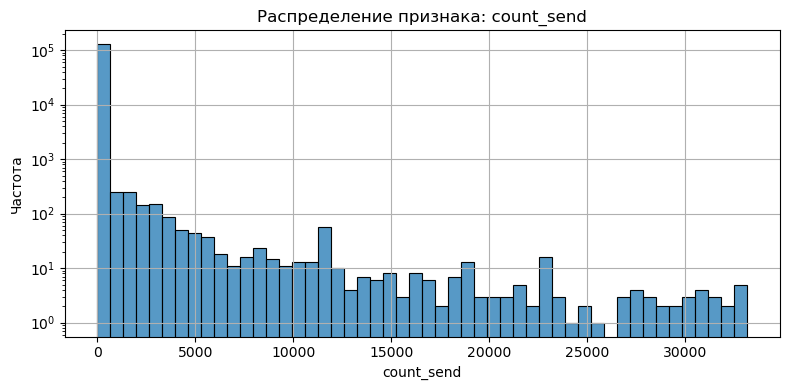

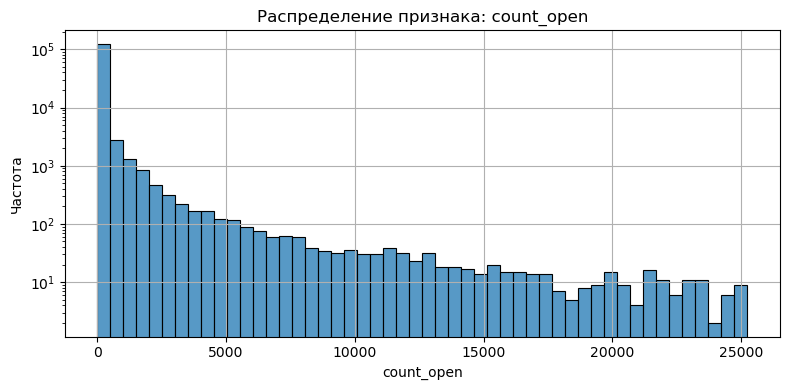

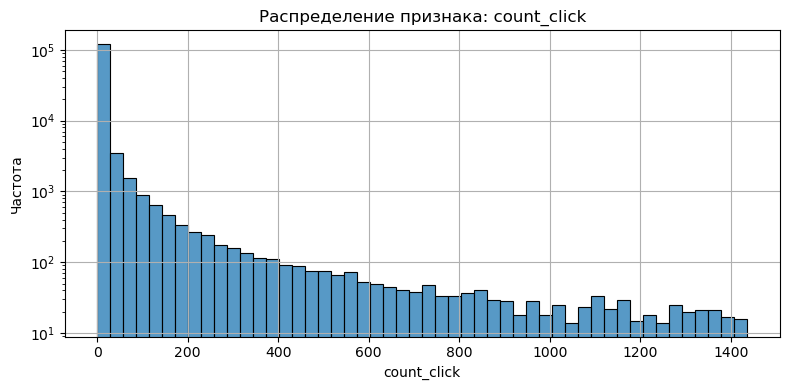

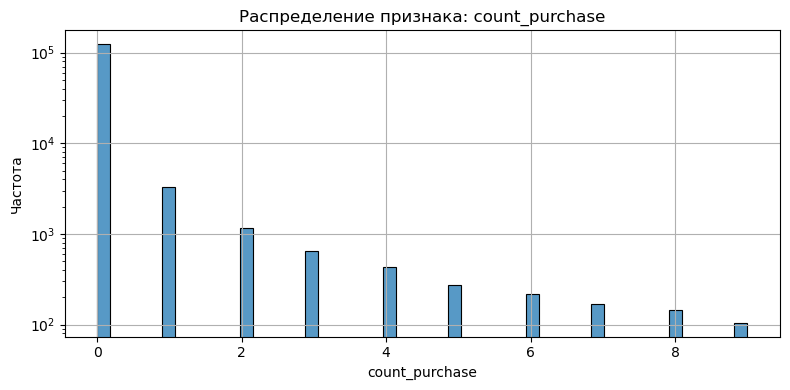

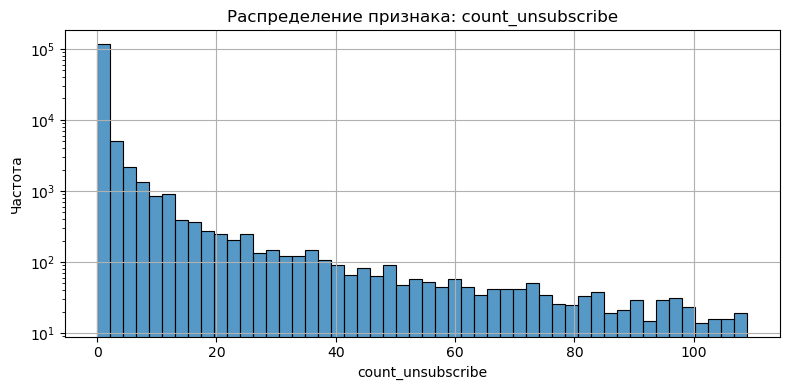

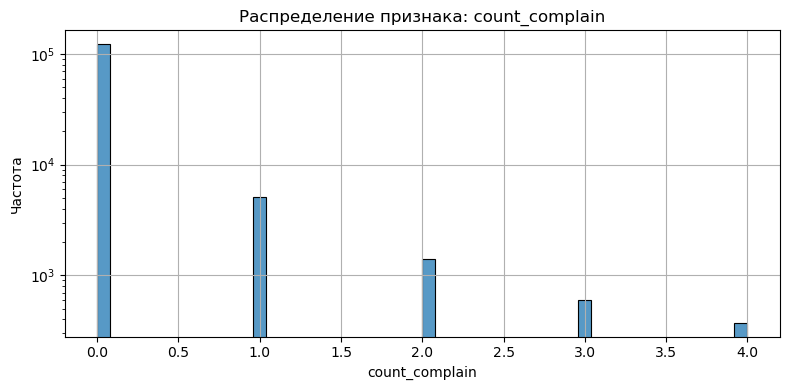

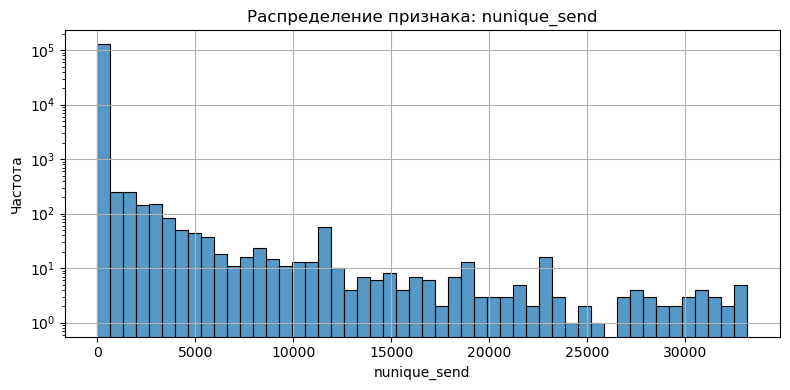

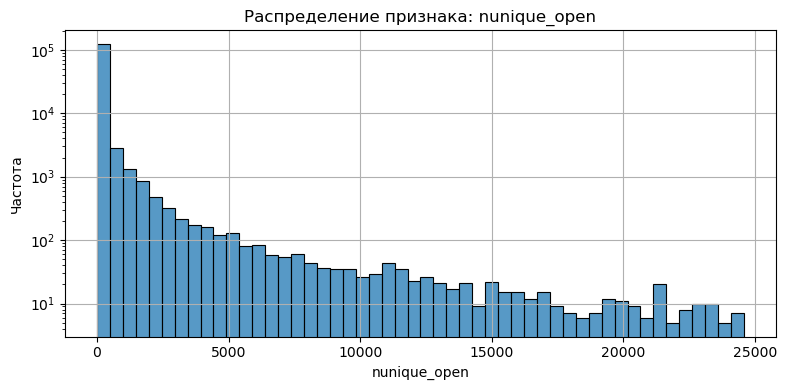

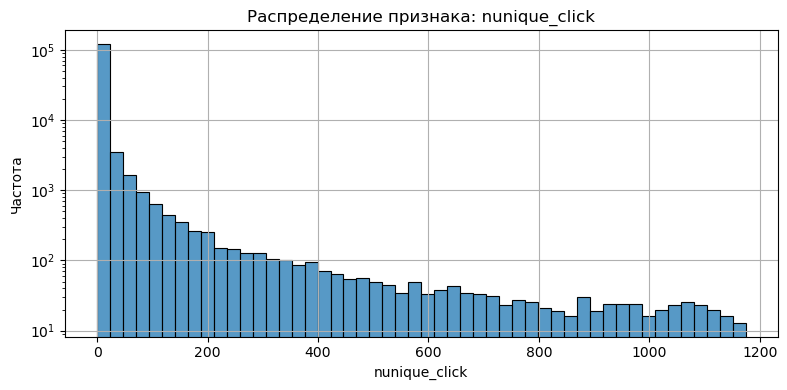

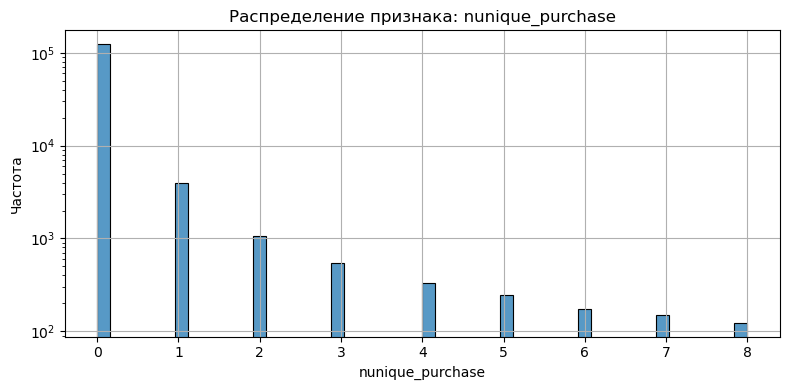

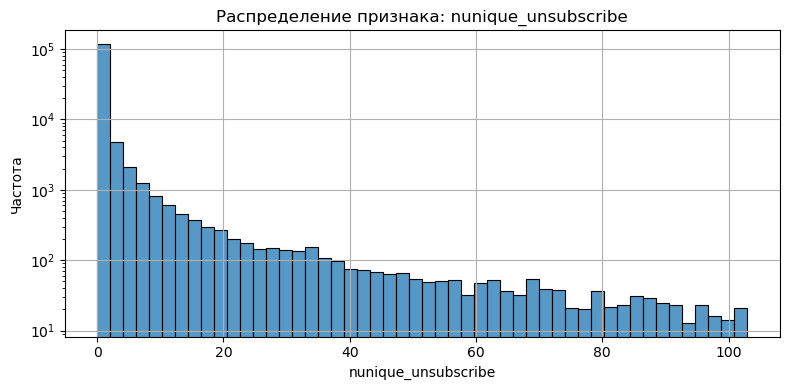

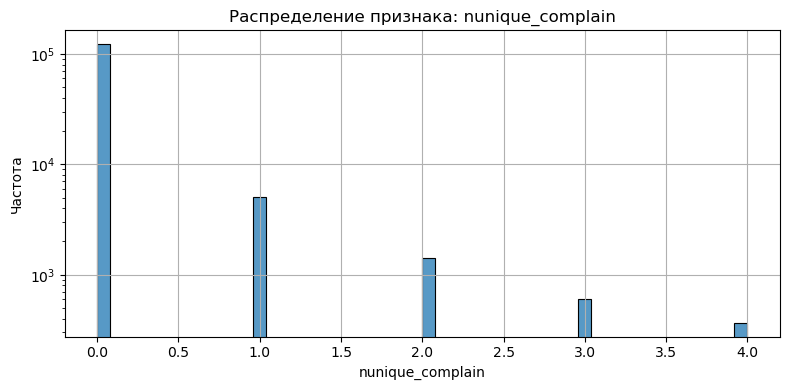

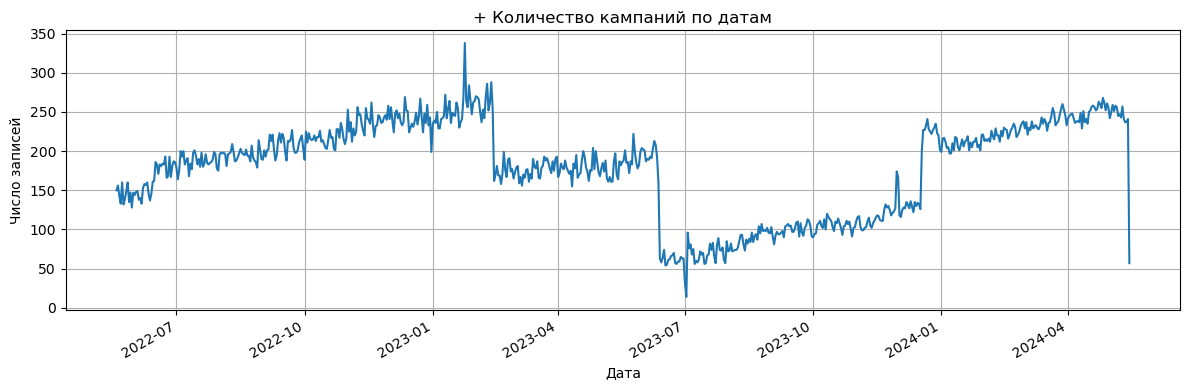

In [17]:
main_count_cols = [
    'count_send', 'count_open', 'count_click', 'count_purchase', 
    'count_unsubscribe', 'count_complain'
]

main_nunique_cols = [
    'nunique_send', 'nunique_open', 'nunique_click', 'nunique_purchase', 
    'nunique_unsubscribe', 'nunique_complain'
]

#  Визуализация count_*
plot_numeric_distribution(campaign_event_df, main_count_cols, log_scale=True)

#  Визуализация nunique_*
plot_numeric_distribution(campaign_event_df, main_nunique_cols, log_scale=True)

# Активность по датам
plt.figure(figsize=(12, 4))
campaign_event_df['date'].value_counts().sort_index().plot()
plt.title('+ Количество кампаний по датам')
plt.xlabel('Дата')
plt.ylabel('Число записей')
plt.grid(True)
plt.tight_layout()
plt.show()



#### Эффективность маркетинговых кампаний

##### Объёмы рассылок (`count_send`)
- Большинство кампаний имеют от 100 до 10 000 отправок, но встречаются и суперкампании с >30 000 сообщений.
- Распределение с сильным правым хвостом — логарифмическая шкала оправдана.
- Кампании по охвату очень разнообразны — от нишевых до массовых.

##### Реакция пользователей (`count_open`, `count_click`, `count_purchase`)
- `count_open` — значительно ниже, чем `count_send`, что ожидаемо (не все читают).
- `count_click` и особенно `count_purchase` — ещё реже. Покупки по кампании происходят в единичных случаях.
- Такая структура подчёркивает воронку: **много отправлено → меньше открыто → ещё меньше кликнули → минимум купили**.

##### Отписки и жалобы (`count_unsubscribe`, `count_complain`)
- Отписки (`unsubscribe`) есть почти у каждой кампании, что важно учитывать при оценке качества рассылки.
- Жалобы (`complain`) встречаются редко, но их появление — серьёзный сигнал для маркетологов.

##### Уникальные пользователи (`nunique_*`)
- Структура почти полностью повторяет count_*:
  - `nunique_send` и `nunique_open` — распределены похоже.
  - `nunique_click` и `nunique_purchase` — крайне ограничены.
- В среднем, **один пользователь участвует в 1–3 кампаниях с реакцией**, что может быть полезным при построении фичей.

##### Активность по датам (`date`)
- Активность кампаний растёт волнообразно:
  - Чётко выражены периоды снижения активности (лето 2023, праздники).
  - С конца 2023 — активность стабильно высокая.
- Кампании носят **регулярный характер** — это позволяет строить признаки по "свежести" участия клиента в кампании.

---

#### Выводы:
- `count_*` и `nunique_*` могут использоваться как поведенческие признаки по каждой кампании.



## Построение признаков для модели

Подготовим единую выборку для дальнейшего анализа важности признаков и обучения модели.

**Группы создаваемых признаков:**
-  Поведенческие признаки по покупкам: общее количество покупок, потраченная сумма, средний чек.
-  Поведенческие признаки по рассылкам: количество сообщений, доля открытий, кликов и покупок после кликов.
-  Канальные признаки: активность в email- и push-каналах.
-  Временные признаки: дата последнего сообщения, время до первой покупки.
-  Признаки эффективности кампаний: открытие писем, клики, покупки на уровне кампаний (агрегаты).



In [18]:
# Поведение по покупкам
purchase_feats = purchases_df.groupby('client_id').agg(
    total_purchases=('message_id', 'count'),
    total_quantity=('quantity', 'sum'),
    total_spent=('price', 'sum'),
    avg_check=('price', 'mean')
).reset_index()

# Активность в рассылках
message_feats = messages_df.groupby('client_id').agg(
    total_messages=('message_id', 'count'),
    open_events=('event', lambda x: (x == 'open').sum()),
    click_events=('event', lambda x: (x == 'click').sum()),
    purchase_events=('event', lambda x: (x == 'purchase').sum())
).reset_index()

message_feats['open_rate'] = message_feats['open_events'] / message_feats['total_messages']
message_feats['click_rate'] = message_feats['click_events'] / message_feats['open_events'].replace(0, 1)
message_feats['purchase_rate'] = message_feats['purchase_events'] / message_feats['click_events'].replace(0, 1)

# Канальные признаки
channel_feats = messages_df.groupby(['client_id', 'channel']).agg(
    messages_by_channel=('message_id', 'count')
).unstack(fill_value=0)

channel_feats.columns = [f'messages_in_{col[1]}' for col in channel_feats.columns]
channel_feats = channel_feats.reset_index()

# Временные признаки
messages_df['date'] = pd.to_datetime(messages_df['date'])
purchases_df['date'] = pd.to_datetime(purchases_df['date'])

time_feats = messages_df.groupby('client_id').agg(
    last_message_date=('date', 'max')
).merge(
    purchases_df.groupby('client_id').agg(
        first_purchase_date=('date', 'min')
    ),
    on='client_id',
    how='left'
)

time_feats['days_between_last_message_and_first_purchase'] = (
    (time_feats['first_purchase_date'] - time_feats['last_message_date']).dt.days
)

time_feats = time_feats.reset_index()

# Признаки по кампаниям
campaign_feats = campaign_event_df.groupby('bulk_campaign_id').agg(
    total_send=('count_send', 'sum'),
    total_open=('count_open', 'sum'),
    total_click=('count_click', 'sum'),
    total_purchase=('count_purchase', 'sum')
).reset_index()

campaign_feats['open_rate_campaign'] = campaign_feats['total_open'] / campaign_feats['total_send'].replace(0, 1)
campaign_feats['click_rate_campaign'] = campaign_feats['total_click'] / campaign_feats['total_open'].replace(0, 1)
campaign_feats['purchase_rate_campaign'] = campaign_feats['total_purchase'] / campaign_feats['total_click'].replace(0, 1)

# Финальное объединение признаков
from functools import reduce

dfs_to_merge = [purchase_feats, message_feats, channel_feats, time_feats]

final_features = reduce(lambda left, right: pd.merge(left, right, on='client_id', how='outer'), dfs_to_merge)

# Добавляем целевую переменную
final_features = final_features.merge(target_df, on='client_id', how='left')

final_features = final_features.dropna(subset=['target'])


Выводы по построению признаков

- Построены поведенческие, канальные и временные признаки для каждого клиента.
- Объединены данные о покупках, активности в рассылках, предпочтениях каналов и времени отклика.
- Финальный датафрейм `final_features` включает все признаки и целевую переменную `target`.
- Данные готовы для анализа важности признаков и обучения моделей.

## Анализ важности признаков
### Корреляционный анализ признаков

Для более точного анализа признаков - проведем два корреляционных анализа:
- Анализ всех признаков без целевого (`target`)
- Анализ всех признаков вместе с целевым признаком

interval columns not set, guessing: ['total_purchases', 'total_quantity', 'total_spent', 'avg_check', 'total_messages', 'open_events', 'click_events', 'purchase_events', 'open_rate', 'click_rate', 'purchase_rate', 'messages_in_email', 'messages_in_mobile_push', 'days_between_last_message_and_first_purchase', 'target']


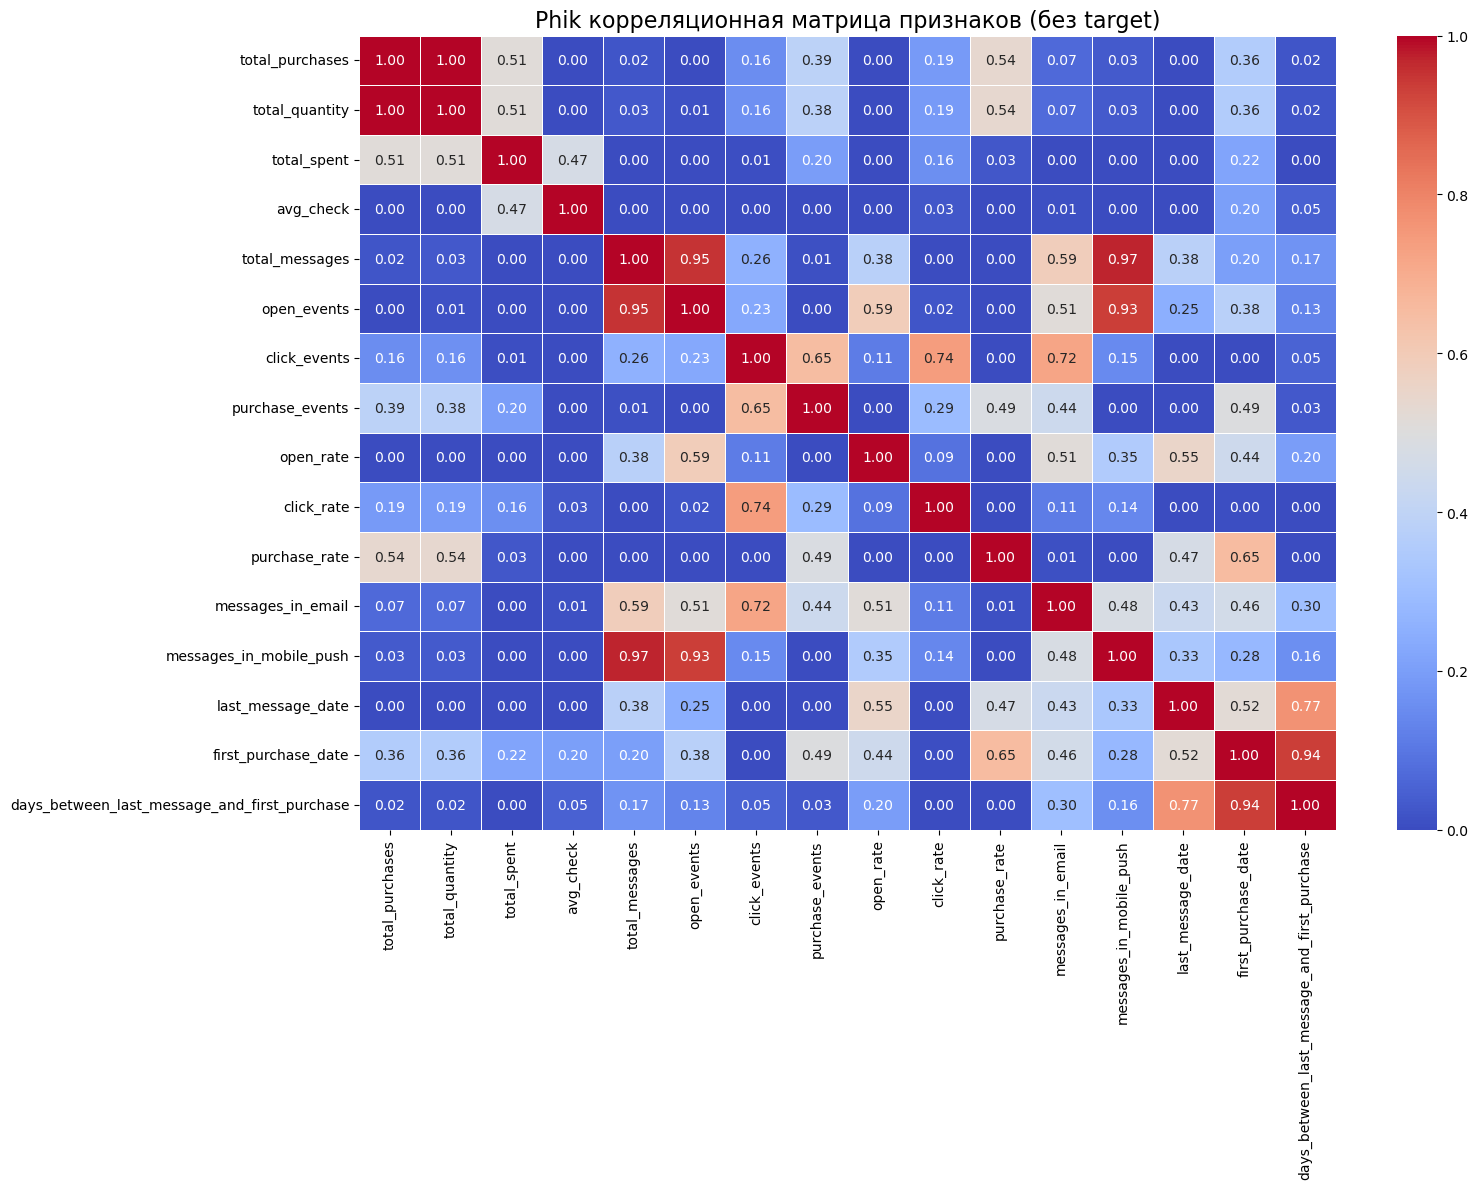

Пары признаков с phik-корреляцией выше 0.7:


,feature_1,feature_2,phik_correlation
0,total_purchases,total_quantity,0.999279
54,total_messages,open_events,0.952592
61,total_messages,messages_in_mobile_push,0.972266
71,open_events,messages_in_mobile_push,0.934447
77,click_events,click_rate,0.741506
79,click_events,messages_in_email,0.721726
118,last_message_date,days_between_last_message_and_first_purchase,0.769299
119,first_purchase_date,days_between_last_message_and_first_purchase,0.935429


Корреляция признаков с целевой переменной (target):


first_purchase_date                             0.124099
total_purchases                                 0.083996
total_quantity                                  0.081293
click_events                                    0.074659
purchase_events                                 0.073965
open_rate                                       0.070301
messages_in_mobile_push                         0.067091
open_events                                     0.060221
click_rate                                      0.055982
total_messages                                  0.052832
days_between_last_message_and_first_purchase    0.044169
total_spent                                     0.034585
messages_in_email                               0.023411
avg_check                                       0.000000
purchase_rate                                   0.000000
last_message_date                               0.000000
Name: target, dtype: float64

In [19]:
features_only = final_features.drop(columns=['client_id'])

phik_corr_matrix = features_only.phik_matrix()

plt.figure(figsize=(16, 12))
sns.heatmap(
    phik_corr_matrix.drop(index='target', columns='target'),  # убираем target
    cmap='coolwarm',
    annot=True,
    fmt=".2f",
    vmin=0,
    vmax=1,
    linewidths=0.5
)
plt.title('Phik корреляционная матрица признаков (без target)', fontsize=16)
plt.tight_layout()
plt.show()

# Поиск пар признаков с высокой корреляцией (> 0.7)
high_corr_pairs = (
    phik_corr_matrix.drop(index='target', columns='target')  # без target
    .where(np.triu(np.ones(phik_corr_matrix.shape[0]-1), k=1).astype(bool))
    .stack()
    .reset_index()
    .rename(columns={0: 'phik_correlation', 'level_0': 'feature_1', 'level_1': 'feature_2'})
)

high_corr_pairs = high_corr_pairs.loc[high_corr_pairs['phik_correlation'] > 0.7]

print('Пары признаков с phik-корреляцией выше 0.7:')
display(high_corr_pairs)

# Отдельный анализ корреляции признаков с целевой переменной target
phik_target_corr = phik_corr_matrix['target'].drop('target').sort_values(ascending=False)

print('Корреляция признаков с целевой переменной (target):')
display(phik_target_corr)


***Выводы по анализу корреляций признаков***

- Построена phik-корреляционная матрица между признаками.
- Выявлены признаки с высокой взаимной корреляцией (phik > 0.7)
- Обнаружены группы признаков, отражающих схожую информацию об активности клиентов, что может привести к избыточности в модели.
- Проведён отдельный анализ корреляции признаков с целевой переменной `target`:
  - Наиболее связанные признаки: `first_purchase_date`, `total_purchases`, `total_quantity`.
  - Большинство признаков имеют низкую корреляцию с `target`, что может быть связано с редкостью целевого события.



### Предварительный отбор признаков

На этом этапе необходимо сократить избыточность данных, удалив:
- признаки, сильно коррелирующие между собой (phik > 0.7);
- признаки, имеющие очень низкую корреляцию с целевой переменной.

In [20]:
feature_columns = final_features.columns.drop(['client_id', 'target']).tolist()

important_features = phik_target_corr[phik_target_corr.abs() > 0.01].index.tolist()

print('Признаки с достаточной связью с целевой переменной:')
print(important_features)


# Список пар с сильной взаимной корреляцией (> 0.7)
features_to_drop = []
phik_corr_features_only = phik_corr_matrix.drop(index='target', columns='target')

for _, row in high_corr_pairs.iterrows():
    f1 = row['feature_1']
    f2 = row['feature_2']
    
    # Если оба признака еще остались в важном списке, один удаляем
    if (f1 in important_features) and (f2 in important_features):
        # Оставляем тот, который имеет большую корреляцию с target
        if phik_target_corr.get(f1, 0) >= phik_target_corr.get(f2, 0):
            features_to_drop.append(f2)
        else:
            features_to_drop.append(f1)

# Удаляем дубли
features_to_drop = list(set(features_to_drop))

print('\nПризнаки, которые будут удалены из-за высокой взаимной корреляции:')
print(features_to_drop)

# Финальный список признаков
final_selected_features = [f for f in important_features if f not in features_to_drop]

print('\n Финальный список признаков для модели:')
print(final_selected_features)


Признаки с достаточной связью с целевой переменной:
['first_purchase_date', 'total_purchases', 'total_quantity', 'click_events', 'purchase_events', 'open_rate', 'messages_in_mobile_push', 'open_events', 'click_rate', 'total_messages', 'days_between_last_message_and_first_purchase', 'total_spent', 'messages_in_email']

Признаки, которые будут удалены из-за высокой взаимной корреляции:
['open_events', 'click_rate', 'total_quantity', 'days_between_last_message_and_first_purchase', 'messages_in_email', 'total_messages']

 Финальный список признаков для модели:
['first_purchase_date', 'total_purchases', 'click_events', 'purchase_events', 'open_rate', 'messages_in_mobile_push', 'total_spent']


***Выводы по предварительному отбору признаков***

- Выбраны признаки с достаточной связью с целевой переменной (`target`), на основе порога phik-корреляции > 0.01.
- Из набора признаков удалены дублирующие признаки, имеющие высокую взаимную корреляцию (phik > 0.7).
- Оставлены наиболее значимые и информативные признаки на основе силы их связи с целевой переменной.

**Итоговый список признаков для построения моделей:**
- `first_purchase_date`
- `total_purchases`
- `open_rate`
- `messages_in_mobile_push`
- `click_rate`
- `purchase_events`
- `total_spent`



## Моделирование и оценка моделей

- Создадим пайплайн для подготовки данных и обучения моделей
- Сравним несколько моделей и выберем лучшую по качеству

In [21]:
# Преобразуем дату покупки в числовой признак
min_date = final_features['first_purchase_date'].min()

final_features['days_since_first_purchase'] = (
    pd.to_datetime(final_features['first_purchase_date']) - pd.to_datetime(min_date)
).dt.days

# Удаляем исходный признак с датой
final_features = final_features.drop(columns=['first_purchase_date'])


In [22]:
num_columns = [
    'days_since_first_purchase', 'total_purchases', 'open_rate',
    'messages_in_mobile_push', 'click_rate', 'purchase_events', 'total_spent'
]

In [23]:
num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

data_preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_columns)
], remainder='passthrough')

In [24]:
X = final_features[num_columns]
y = final_features['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

In [25]:
pipe = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', LogisticRegression())  # Заглушка, модель будет заменяться в RandomizedSearchCV
])

param_grid = [
    {
        'model': [LogisticRegression(max_iter=1000, random_state=42)],
        'model__C': [0.01, 0.1, 1, 10]
    },
    {
        'model': [RandomForestClassifier(random_state=42)],
        'model__n_estimators': [100, 200, 500],
        'model__max_depth': [5, 10, 20, None]
    },
    {
        'model': [GradientBoostingClassifier(random_state=42)],
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__max_depth': [3, 5, 7]
    },
    {
        'model': [CatBoostClassifier(random_state=42, verbose=0)],
        'model__iterations': [300, 500],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__depth': [4, 6, 8]
    }
]


In [26]:
search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_grid,
    n_iter=10,   
    scoring='roc_auc',  
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['days_since_first_purchase',
                                                                                'total_purchases',
                                                                                'open_rate',
                                                                                'messages_in_mobile_push',
                                                                                'click_rate',
                                                                                'purchase_events',
                                                                                'total_spent'])])),
                                             ('model', LogisticRegression())]),
                   n_jobs=...
                                        {'model': [GradientBoostingClassifier(random_state=42)],
                                         'model__learning_rate': [0.01, 0.05,
                                                                  0.1],
                                         'model__max_depth': [3, 5, 7],
                                         'model__n_estimators': [100, 200]},
                                        {'model': [<catboost.core.CatBoostClassifier object at 0x000002694FC2FF50>],
                                         'model__depth': [4, 6, 8],
                                         'model__iterations': [300, 500],
                                         'model__learning_rate': [0.01, 0.05,
                                                                  0.1]}],
                   random_state=42, scoring='roc_auc', verbose=1)

In [27]:
print(f'Лучшая модель: {search.best_estimator_["model"]}')
print('Параметры модели:', search.best_params_)
print(f'Лучший ROC-AUC на кросс-валидации: {search.best_score_:.4f}')

Лучшая модель: <catboost.core.CatBoostClassifier object at 0x0000026971F1A090>
Параметры модели: {'model__learning_rate': 0.01, 'model__iterations': 500, 'model__depth': 6, 'model': <catboost.core.CatBoostClassifier object at 0x000002694FC2FF50>}
Лучший ROC-AUC на кросс-валидации: 0.7122


### Оценка качества модели

In [28]:
# Обучаем найденную лучшую модель
best_model = search.best_estimator_

best_model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['days_since_first_purchase',
                                                   'total_purchases',
                                                   'open_rate',
                                                   'messages_in_mobile_push',
                                                   'click_rate',
                                                   'purchase_events',
                                                   'total_spent'])])),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x0000026971F1A090>)])

In [29]:
# Предсказание вероятностей положительного класса
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Предсказание меток классов
y_pred = best_model.predict(X_test)

ROC-AUC на тестовой выборке: 0.7196


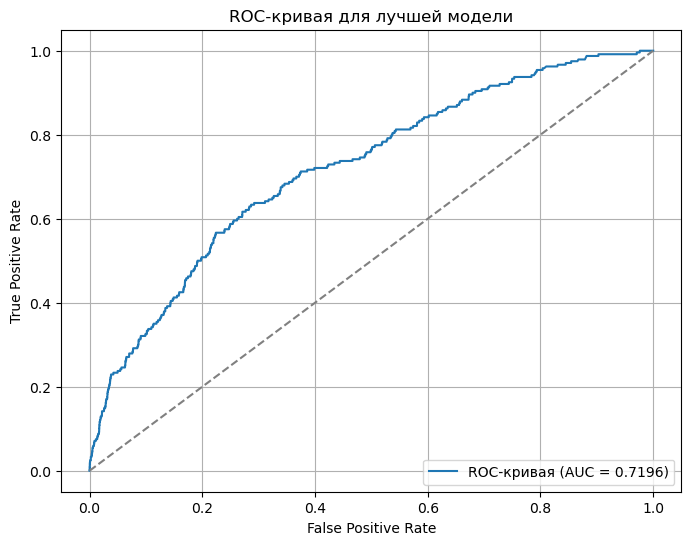

In [30]:
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix

# ROC-AUC на тесте
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC на тестовой выборке: {roc_auc:.4f}")

# Построение ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC-кривая (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая для лучшей модели')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [31]:
print('📄 Classification Report:')
print(classification_report(y_test, y_pred))

📄 Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     12223
         1.0       0.00      0.00      0.00       240

    accuracy                           0.98     12463
   macro avg       0.49      0.50      0.50     12463
weighted avg       0.96      0.98      0.97     12463



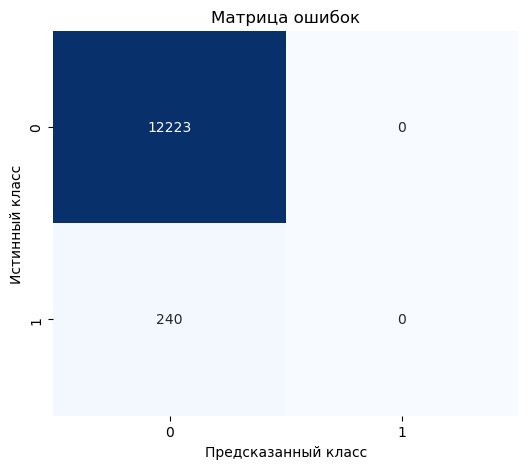

In [32]:
# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок')
plt.show()

***Выводы***
- 12223 клиентов без покупки правильно предсказаны как "нет покупки" (0).

- 240 клиентов с покупкой ошибочно предсказаны как "нет покупки" (0).

- Вообще нет предсказанных единиц (1) — модель НИКОГО не отнесла к покупателям!

Скорее всего произошло это из-за сильной несбалансированности классов.
Постараемся подобрать другой порог классификации для более точной работы модели

In [33]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Зададим список порогов для перебора
thresholds = np.arange(0.1, 0.6, 0.05)  # от 0.10 до 0.55 с шагом 0.05

# Сохраним результаты
metrics_table = []

for threshold in thresholds:
    y_pred_thresh = (y_pred_proba >= threshold).astype(int)
    
    precision = precision_score(y_test, y_pred_thresh)
    recall = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)
    
    metrics_table.append({
        'Порог': threshold,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1
    })

# Переводим в DataFrame для наглядности
metrics_df = pd.DataFrame(metrics_table)

# Красиво выводим
print('📊 Метрики на разных порогах классификации:')
display(metrics_df.style.background_gradient(cmap='Blues').format({'Порог':'{:.2f}', 'Precision':'{:.2f}', 'Recall':'{:.2f}', 'F1-score':'{:.2f}'}))


📊 Метрики на разных порогах классификации:


,Порог,Precision,Recall,F1-score
0,0.10,0.16,0.03,0.05
1,0.15,0.29,0.02,0.04
2,0.20,0.43,0.01,0.02
3,0.25,0.33,0.01,0.02
4,0.30,0.67,0.01,0.02
5,0.35,0.00,0.00,0.00
6,0.40,0.00,0.00,0.00
7,0.45,0.00,0.00,0.00
8,0.50,0.00,0.00,0.00
9,0.55,0.00,0.00,0.00


***Вывыды***
- При порогах выше 0.30 модель почти перестаёт находить положительные классы (recall = 0.00).

- На маленьких порогах (0.10–0.30) хоть и очень низкий recall, но он хоть как-то ненулевой.

- F1-score во всех случаях крайне низкий, потому что покупатели — редкость в выборке.

Модель все еще плохо различает покупателей, даже при хорошей метрике ROC-AUC. Чтобы хоть кто-то из покупателей начал выделияться моделью - поставим порог классификации 0.1

📄 Classification Report при пороге 0.1:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     12223
         1.0       0.16      0.03      0.05       240

    accuracy                           0.98     12463
   macro avg       0.57      0.51      0.52     12463
weighted avg       0.97      0.98      0.97     12463



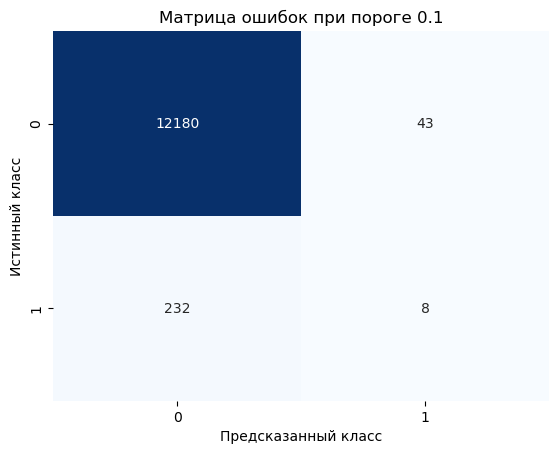

In [34]:
best_threshold = 0.10

y_pred_best = (y_pred_proba >= best_threshold).astype(int)

print(f'📄 Classification Report при пороге {best_threshold}:')
print(classification_report(y_test, y_pred_best))

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title(f'Матрица ошибок при пороге {best_threshold}')
plt.show()


***Вывод по этапу создания новых признаков и переобучения моделей***

На данном этапе проекта была предпринята попытка генерации новых признаков для улучшения качества модели:
- Проведено создание дополнительных фич на основе имеющихся данных о покупках и сообщениях.
- Построены и переобучены модели с расширенным набором признаков.
- Проведён пересчёт метрик качества, включая Precision, Recall и F1-score.

В ходе проекта был выявлен сильный дисбаланс классов: положительный класс ("совершение покупки") встречается значительно реже.

Однако, по результатам моделирования:
- Текущая модель CatBoost продемонстрировала ROC-AUC ≈ 0.71 без применения сэмплинга.
- Попытки балансировки могли привести к потере информации (при андерсемплинге) или к переобучению (при оверсэмплинге).

На основании анализа было принято решение **не использовать методы балансировки классов** в этом проекте, чтобы сохранить стабильность и обобщающую способность модели.

На основании анализа принято решение **остановить генерацию новых признаков** и **закрепить текущую версию модели** как финальную:
- Текущая модель демонстрирует разумный баланс между качеством и сложностью.
- Дальнейшее усложнение модели нецелесообразно с точки зрения затрат времени и увеличения риска переобучения.




<div class="alert alert-info">
<h2> Комментарий разработчика <a class="tocSkip"> </h2>

Отдельно была попытка создания новых признаков. Но такой метод не дал новых результатов. В некоторых случаих даже ухудшал их.

Исследования сильно загромождали проект без видимой значимости, поэтому не представлены здесь

</div>

## Финальные выводы по проекту

В рамках проекта была проведена комплексная аналитика клиентских покупок и построение модели для предсказания совершения покупок.

### Основные этапы проекта:

1. **Загрузка и первичный осмотр данных**:
   - Успешно загружены и изучены данные из пяти файлов, содержавших информацию о покупках, сообщениях и кампаниях.

2. **Предобработка данных**:
   - Выполнена очистка от пропусков и дубликатов.
   - Приведены типы данных к корректным форматам (например, даты).

3. **Разведочный анализ данных (EDA)**:
   - Исследованы распределения ключевых признаков: покупки, стоимость, количество сообщений и событий кампаний.
   - Выявлены сильные дисбалансы классов и редкость событий "покупка".

4. **Проверка связей между таблицами**:
   - Подтверждено соответствие клиентов и сообщений между разными датасетами.
   - Убедились, что данные корректно объединяются через `client_id` и `message_id`.

5. **Формирование финального набора признаков**:
   - Проведён корреляционный анализ с использованием `phik_matrix`.
   - Выбраны признаки с наибольшей связью с целевой переменной и устранены высоко коррелирующие между собой признаки.

6. **Построение моделей и подбор гиперпараметров**:
   - Создан пайплайн обработки данных и обучения моделей через `RandomizedSearchCV`.
   - Лучшей моделью стал **CatBoostClassifier** с ROC-AUC ≈ **0.71** на кросс-валидации.

7. **Создание новых признаков**:
   - Генерация дополнительных признаков не привела к улучшению качества модели, поэтому финальная версия осталась на основе отобранных исходных данных.

8. **Оценка качества и подбор порогов**:
   - Исследовано влияние порога классификации на Precision, Recall и F1-score.
   - Зафиксировано сильное влияние классового дисбаланса на качество распознавания событий покупки.

---

###  Рекомендации:

- Для повышения качества моделей в будущем рекомендуется:
  - Увеличить размер обучающей выборки за счёт привлечения новых данных.
  - Проводить более глубокую сегментацию клиентов по их активностям.
  - Включить дополнительные внешние источники данных: поведенческие метрики, клики, переходы на сайт и т.д.


